# Import Dataset, drop 0 columns

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_csv_files(folder_path):
  cleaned_dataframes = {}

  # List of columns to drop
  columns_to_drop = [
      "status", "start_date", "end_date", "window_start_date", "window_end_date",
      "emails", "devs", "emails_thread_starter", "emails_thread_starter_word_count",
      "emails_thread_starter_characters", "emails_threads", "emails_threads_word_count",
      "emails_threads_characters", "emails_no_replies", "emails_no_replies_word_count",
      "emails_no_replies_characters", "emails_jira", "most_complex_unit_loc",
      "most_complex_unit_mcabe_index", "total_number_of_files", "number_of_files_main",
      "lines_of_code_main", "number_of_files_test", "lines_of_code_test",
      "test_vs_main_lines_of_code_percentage", "number_of_files_generated",
      "lines_of_code_generated", "number_of_files_build_and_deployment",
      "lines_of_code_build_and_deployment", "negligible_risk_file_size_count",
      "low_risk_file_size_count", "medium_risk_file_size_count", "high_risk_file_size_count",
      "very_high_risk_file_size_count", "negligible_risk_file_size_loc", "low_risk_file_size_loc",
      "medium_risk_file_size_loc", "high_risk_file_size_loc", "very_high_risk_file_size_loc",
      "number_of_units", "lines_of_code_in_units", "lines_of_code_outside_units",
      "unit_size_negligible_risk_loc", "unit_size_negligible_risk_count", "unit_size_low_risk_loc",
      "unit_size_low_risk_count", "unit_size_medium_risk_loc", "unit_size_medium_risk_count",
      "unit_size_high_risk_loc", "unit_size_high_risk_count", "unit_size_very_high_risk_loc",
      "unit_size_very_high_risk_count", "conditional_complexity_negligible_risk_loc",
      "conditional_complexity_negligible_risk_count", "conditional_complexity_low_risk_loc",
      "conditional_complexity_low_risk_count", "conditional_complexity_medium_risk_loc",
      "conditional_complexity_medium_risk_count", "conditional_complexity_high_risk_loc",
      "conditional_complexity_high_risk_count", "conditional_complexity_very_high_risk_loc",
      "conditional_complexity_very_high_risk_count", "conditional_complexity_high_plus_risk_count",
      "conditional_complexity_high_plus_risk_loc", "number_of_contributors",
      "duplication_number_of_duplicates", "duplication_number_of_files_with_duplicates",
      "duplication_number_of_duplicated_lines", "duplication_percentage", "unit_duplicates_count", "releases"
  ]

  for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
      file_path = os.path.join(folder_path, filename)

      # Load CSV file
      df = pd.read_csv(file_path)

      # Drop specified columns
      df = df.drop(
          columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

      key = os.path.splitext(filename)[0]
      cleaned_dataframes[key] = df

  return cleaned_dataframes

folder_path = "scraper-output"
cleaned_data = clean_csv_files(folder_path)


# Clean data

In [3]:
import pandas as pd
import numpy as np

for key, df in cleaned_data.items():
    # Replace NaN values in numerical columns with 0
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)

    # Replace NaN and blank/empty values in 'programming_lang' column with the mode
    if 'programming_lang' in df.columns:
        # Calculate mode value
        mode_value = df['programming_lang'].mode()[0] if not df['programming_lang'].mode().empty else 'Unknown'
        
        # Replace NaN values with the mode
        df['programming_lang'] = df['programming_lang'].fillna(mode_value)
        
        # Replace blank or whitespace-only values with the mode
        df['programming_lang'] = df['programming_lang'].replace(r'^\s*$', mode_value, regex=True)

# Compute PCA to rank relevance of features

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_on_each(cleaned_data):
  feature_importance_list = []

  for key, df in cleaned_data.items():
    # Exclude 'project', 'measurement_month', and 'programming_lang' columns
    features = df.drop(
        columns=['project', 'measurement_month', 'programming_lang'], errors='ignore')

    # Handle missing values - fill or drop NaNs
    features = features.fillna(0)

    # Drop columns with zero variance
    features = features.loc[:, features.var() > 0]

    # Check if there are any numeric features left
    numeric_features = features.select_dtypes(include=[np.number])
    if numeric_features.empty:
      print(
          f"Warning: No numeric features left for PCA in {key}. Skipping PCA.")
      continue

    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numeric_features)

    # Perform PCA
    pca = PCA()
    pca.fit(scaled_features)

    # Collect feature importance
    feature_importance = dict(
        zip(numeric_features.columns, pca.explained_variance_ratio_))
    feature_importance_list.append(feature_importance)

  # Compute average importance across all DataFrames
  avg_feature_importance = {}
  for feature_dict in feature_importance_list:
    for feature, importance in feature_dict.items():
      if feature not in avg_feature_importance:
        avg_feature_importance[feature] = []
      avg_feature_importance[feature].append(importance)

  # Compute final average
  avg_feature_importance = {feature: sum(
      values) / len(values) for feature, values in avg_feature_importance.items()}

  # Rank features by average importance
  ranked_features = sorted(avg_feature_importance.items(),
                           key=lambda x: x[1], reverse=True)

  # Display ranked features
  print("Final Ranked Features by Average Importance:")
  for feature, importance in ranked_features:
    print(f"{feature}: {importance:.4f}")


# Perform PCA on each DataFrame and compute overall importance
perform_pca_on_each(cleaned_data)

Final Ranked Features by Average Importance:
commits: 0.3743
authors: 0.1941
committers: 0.1070
minor_contributors: 0.0689
major_contributors: 0.0564
directories: 0.0438
top_level_dirs: 0.0367
active_days: 0.0298
files_modified: 0.0242
files_added: 0.0195
files_deleted: 0.0156
files_renamed: 0.0124
added_lines: 0.0094
deleted_lines: 0.0072
new_contributors: 0.0054
avg_files_modified_commit: 0.0040
code: 0.0028
blanks: 0.0020
files: 0.0014
comments: 0.0009
lines: 0.0005
stars: 0.0003
forks: 0.0002
open_prs: 0.0002
closed_prs: 0.0001
merged_prs: 0.0000
stale_prs: 0.0000
deploys: 0.0000


In [5]:
status_data = pd.read_csv("project-status.csv")
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   project  154 non-null    object
 1   status   154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


# Time series analysis on most important features

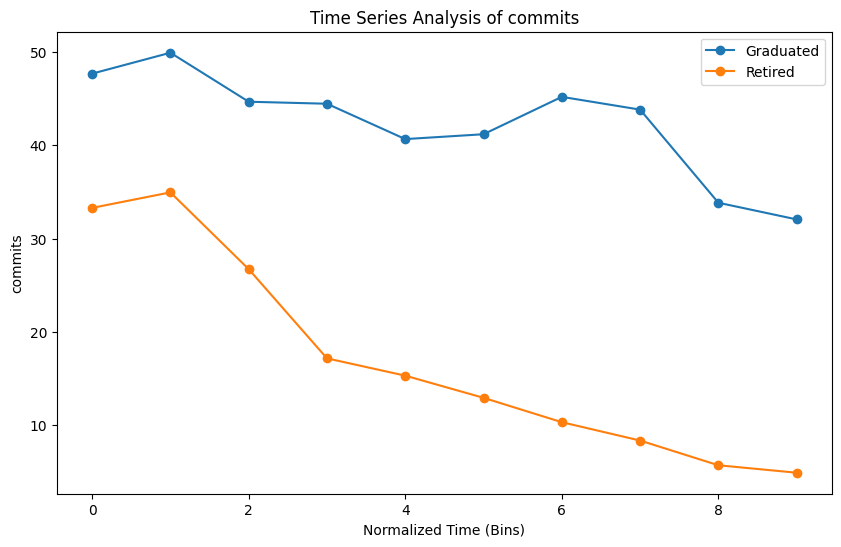

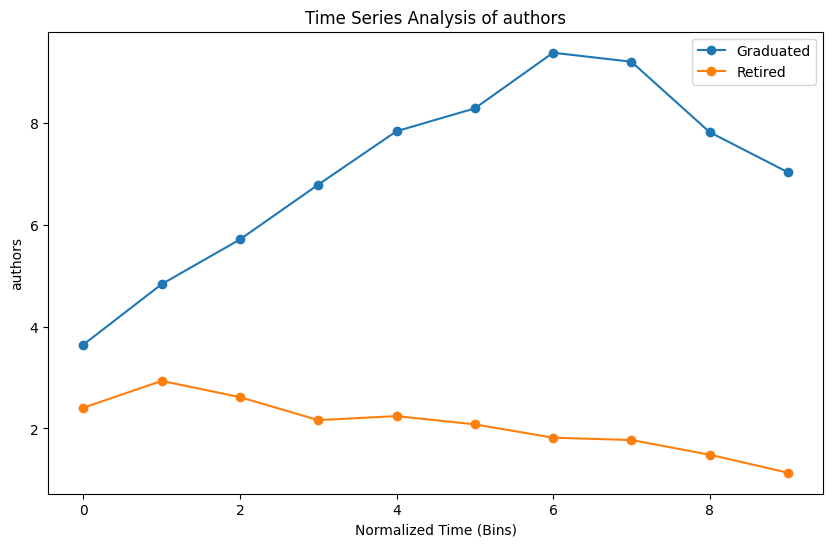

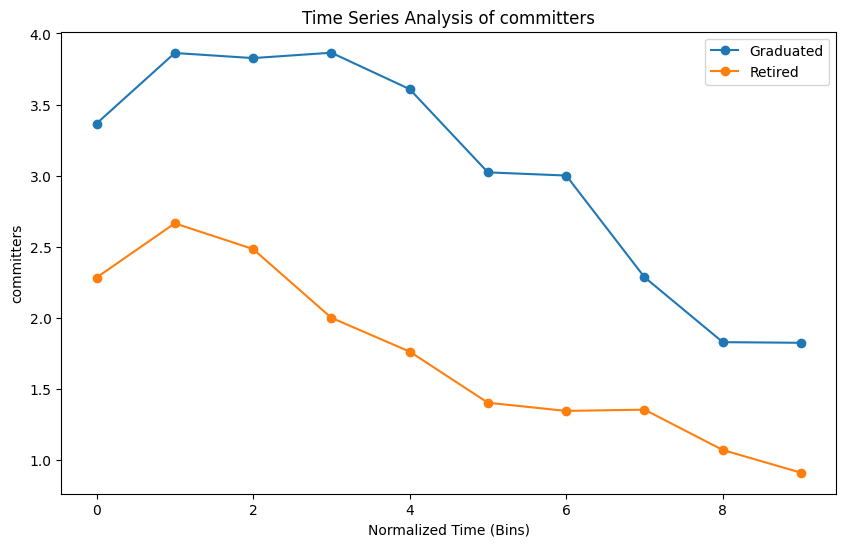

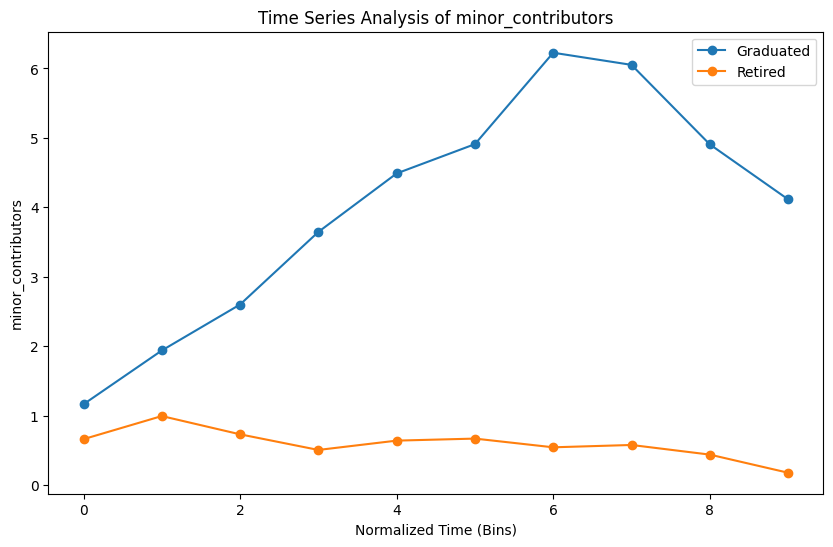

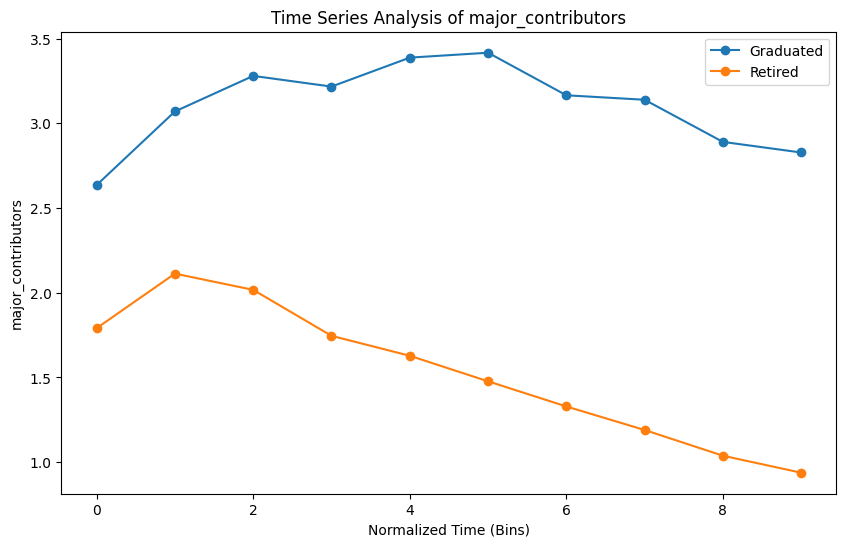

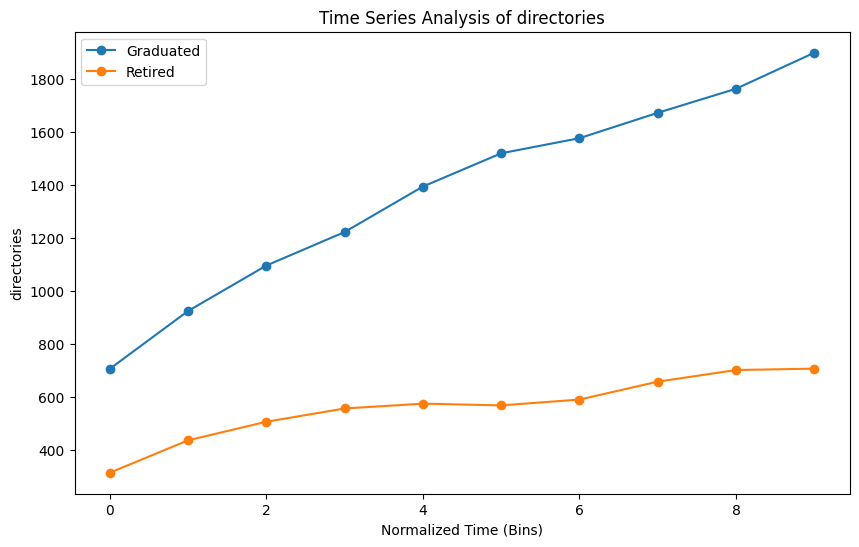

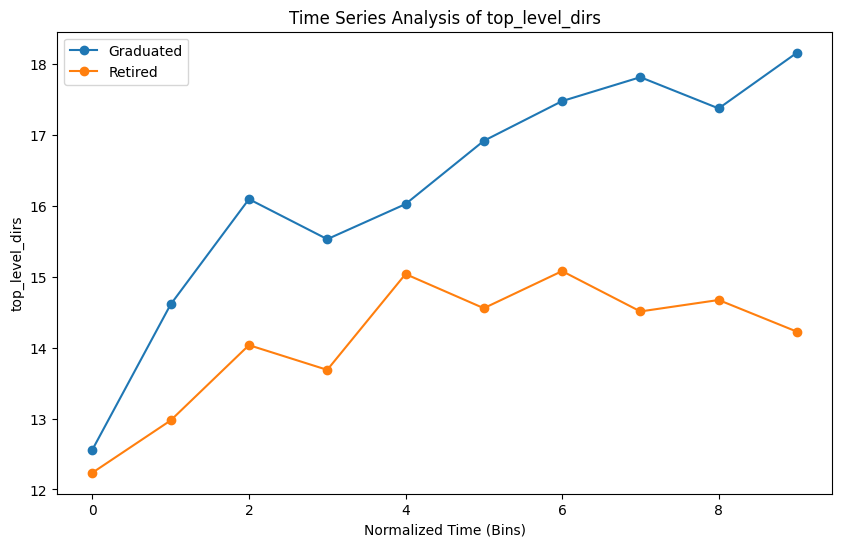

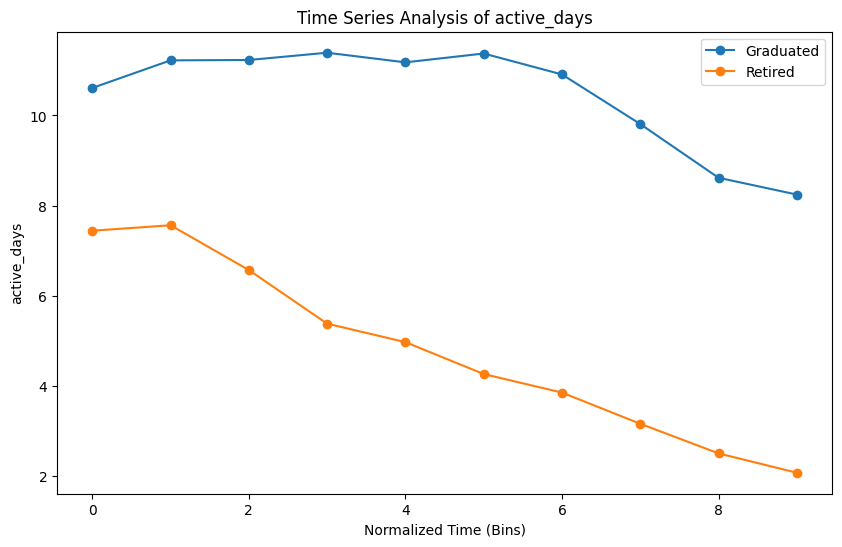

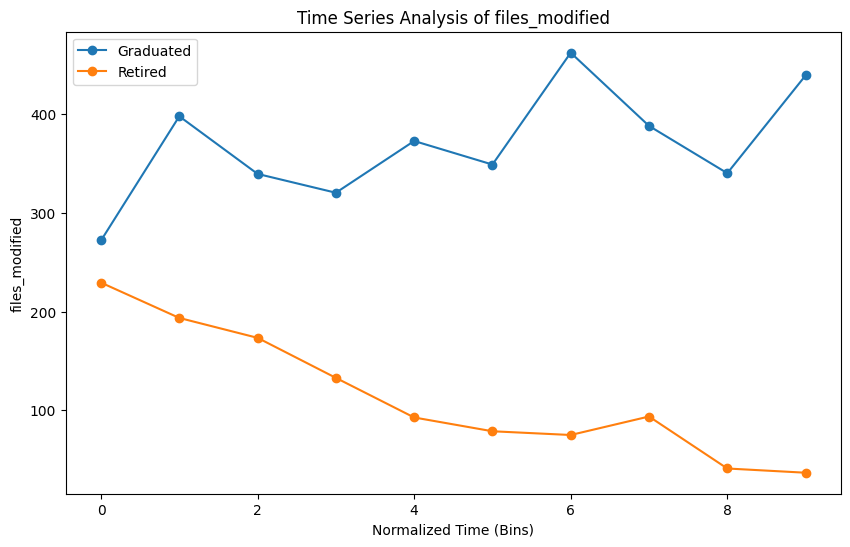

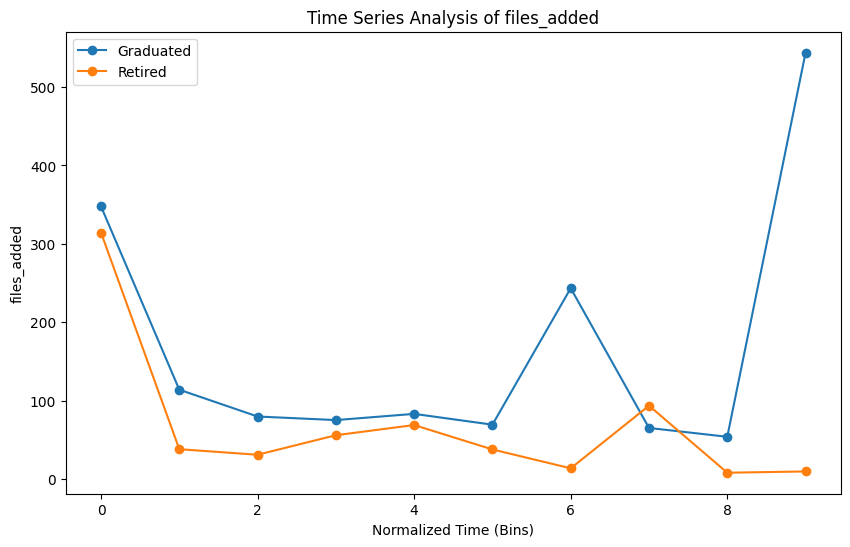

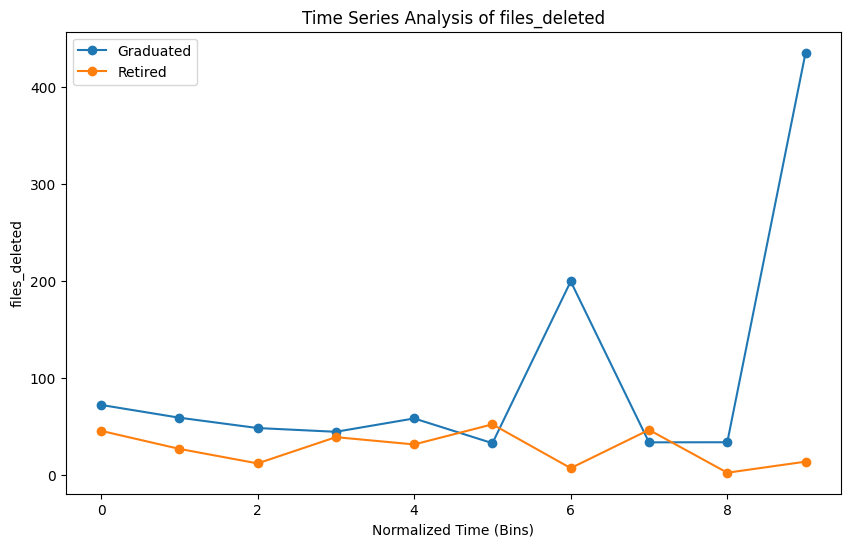

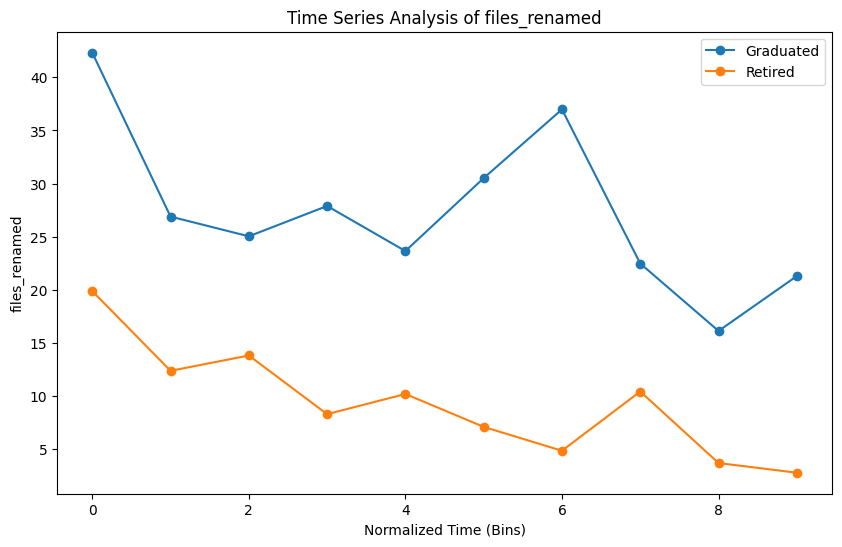

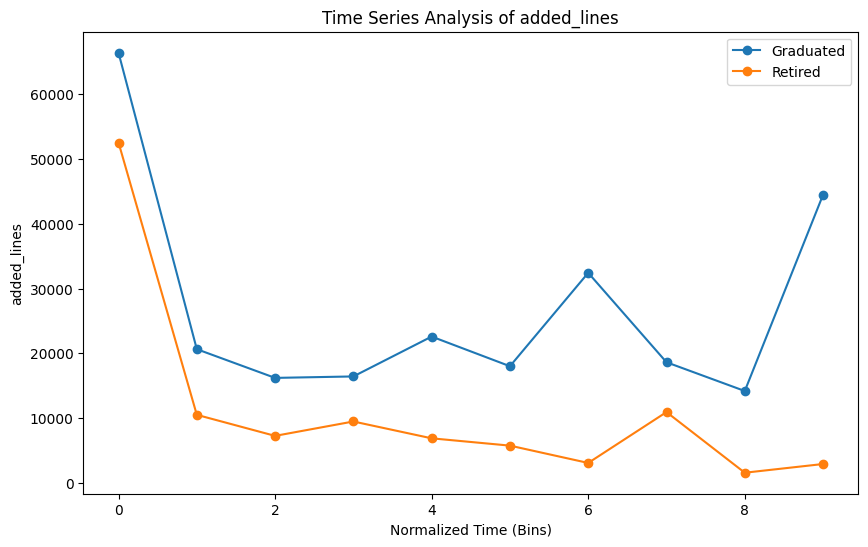

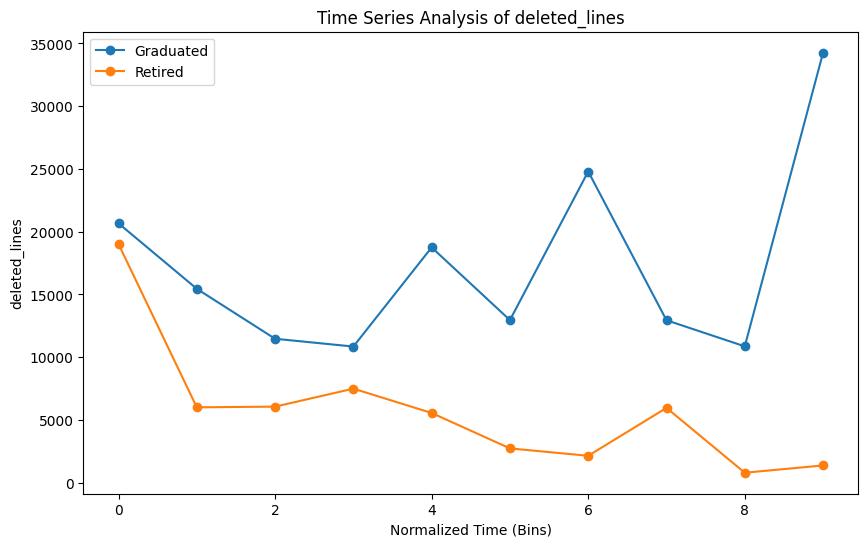

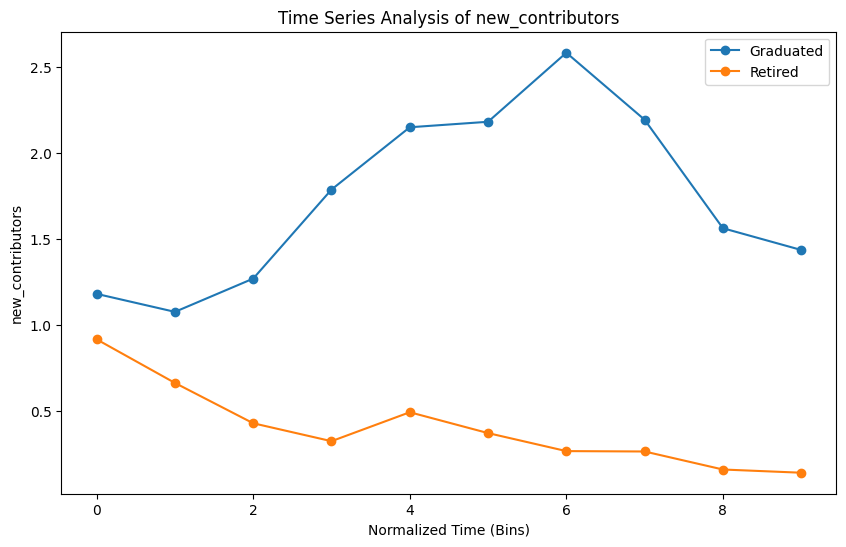

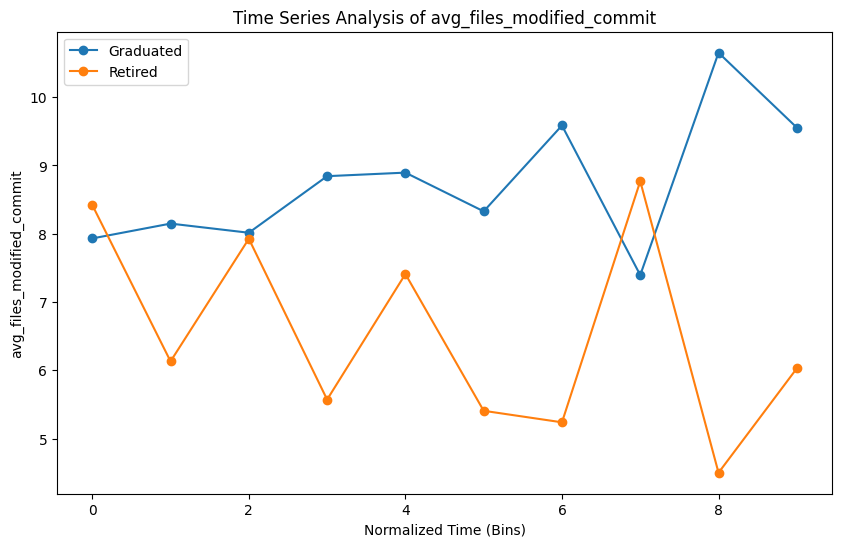

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project,
                df in cleaned_data.items() if len(df) >= 10}

# Filter status_data to only include projects present in cleaned_data
status_data_filtered = status_data[status_data['project'].isin(
    cleaned_data.keys())]


# Merge project status into each dataframe
def merge_status(cleaned_data, status_data):
  status_dict = status_data.set_index('project')['status'].to_dict()
  for project, df in cleaned_data.items():
    df['status'] = status_dict.get(project, 'Unknown')
  return cleaned_data

# Function to extract 1/10th segments and compute averages
def extract_average_feature(df, feature, num_bins=10):
  df = df.sort_values(by='measurement_month')  # Ensure time is sorted
  bin_size = max(1, len(df) // num_bins)  # Determine bin size
  averages = [df[feature].iloc[i *
                               bin_size: (i + 1) * bin_size].mean() for i in range(num_bins)]
  return averages

# Function to plot feature trends
def plot_feature(cleaned_data, status_data, feature, num_bins=10):
  cleaned_data = merge_status(cleaned_data, status_data)

  # Collect averaged data for each status
  grouped_data = {status: [[] for _ in range(
      num_bins)] for status in status_data['status'].unique()}
  for project, df in cleaned_data.items():
    if feature in df.columns:
      status = df['status'].iloc[0]
      averages = extract_average_feature(df, feature, num_bins)
      for i, avg in enumerate(averages):
        grouped_data[status][i].append(avg)

  # Compute overall average per bin for each status group
  plt.figure(figsize=(10, 6))
  for status, bins in grouped_data.items():
    avg_series = [
        np.mean(bin_values) if bin_values else 0 for bin_values in bins]
    plt.plot(range(num_bins), avg_series, marker='o', label=status)

  plt.xlabel('Normalized Time (Bins)')
  plt.ylabel(feature)
  plt.title(f'Time Series Analysis of {feature}')
  plt.legend()
  plt.show()

# Function to plot all features
def plot_all_features(cleaned_data, status_data, features, num_bins=10):
  for feature in features:
    plot_feature(cleaned_data, status_data, feature, num_bins)


plot_all_features(cleaned_data, status_data, [
    'commits', 'authors', 'committers', 'minor_contributors', 'major_contributors',
    'directories', 'top_level_dirs', 'active_days', 'files_modified', 'files_added',
    'files_deleted', 'files_renamed', 'added_lines', 'deleted_lines', 'new_contributors',
    'avg_files_modified_commit'
])

# Base case classification (condensing each project data to a single column)


Training Logistic Regression...


/home/han/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/han/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test Classification Report for Logistic Regression:
               precision    recall  f1-score   support

   Graduated       0.75      0.88      0.81        17
     Retired       0.82      0.64      0.72        14

    accuracy                           0.77        31
   macro avg       0.78      0.76      0.77        31
weighted avg       0.78      0.77      0.77        31

Top 5 important features for Logistic Regression: ['major_contributors_std' 'major_contributors_mean' 'active_days_std'
 'active_days_mean' 'new_contributors_trend']


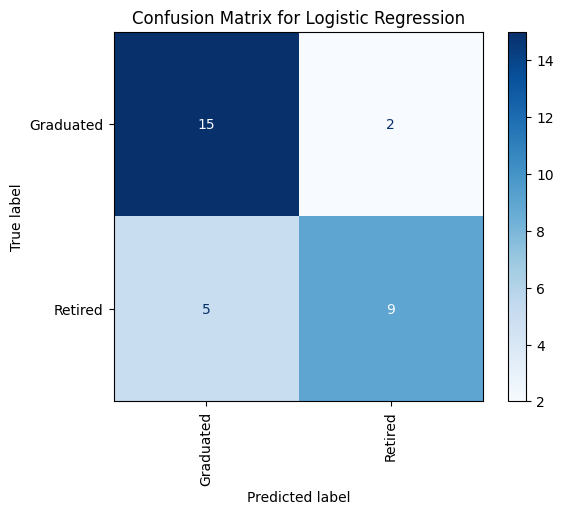


Training SVM...
Test Classification Report for SVM:
               precision    recall  f1-score   support

   Graduated       0.63      0.71      0.67        17
     Retired       0.58      0.50      0.54        14

    accuracy                           0.61        31
   macro avg       0.61      0.60      0.60        31
weighted avg       0.61      0.61      0.61        31

Top 5 important features for SVM: ['files_renamed_std' 'commits_std' 'programming_lang_Scala'
 'programming_lang_Java' 'programming_lang_C']


/home/han/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


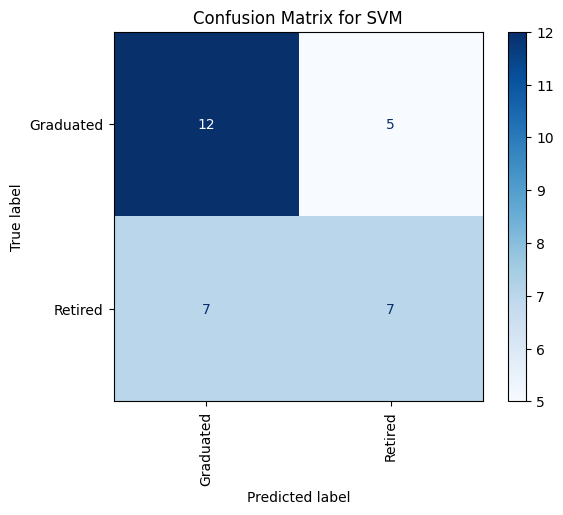


Training Decision Tree...
Test Classification Report for Decision Tree:
               precision    recall  f1-score   support

   Graduated       0.61      0.82      0.70        17
     Retired       0.62      0.36      0.45        14

    accuracy                           0.61        31
   macro avg       0.62      0.59      0.58        31
weighted avg       0.62      0.61      0.59        31

Decision Tree does not have coefficients to display.


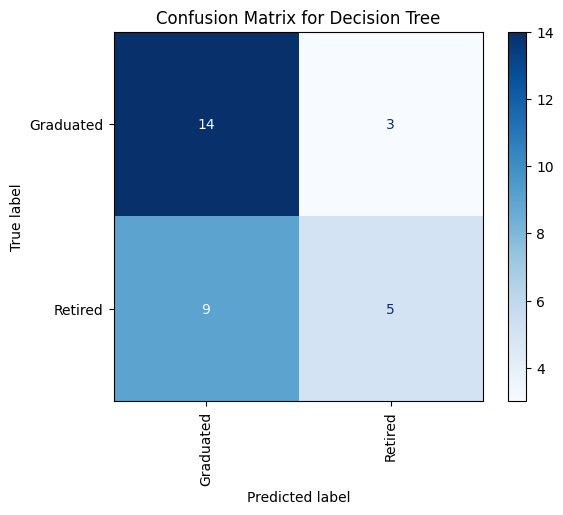


Training Random Forest...
Test Classification Report for Random Forest:
               precision    recall  f1-score   support

   Graduated       0.68      0.88      0.77        17
     Retired       0.78      0.50      0.61        14

    accuracy                           0.71        31
   macro avg       0.73      0.69      0.69        31
weighted avg       0.73      0.71      0.70        31

Random Forest does not have coefficients to display.


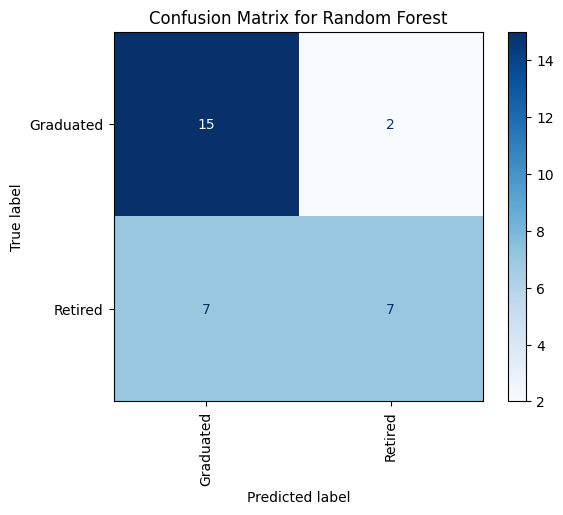


Training k-NN...
Test Classification Report for k-NN:
               precision    recall  f1-score   support

   Graduated       0.67      0.71      0.69        17
     Retired       0.62      0.57      0.59        14

    accuracy                           0.65        31
   macro avg       0.64      0.64      0.64        31
weighted avg       0.64      0.65      0.64        31

k-NN does not have coefficients to display.


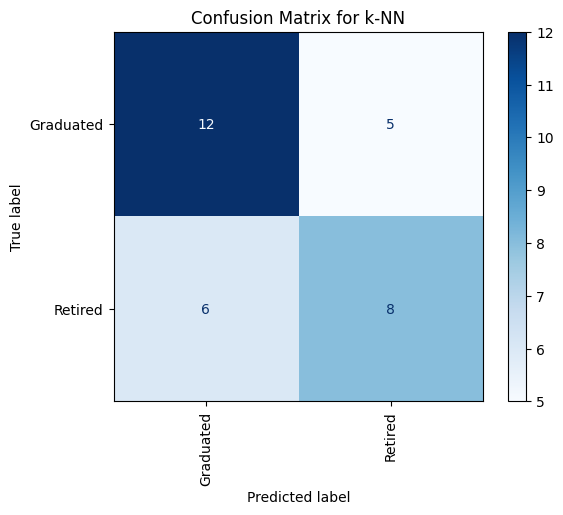


Training Naive Bayes...
Test Classification Report for Naive Bayes:
               precision    recall  f1-score   support

   Graduated       0.71      0.59      0.65        17
     Retired       0.59      0.71      0.65        14

    accuracy                           0.65        31
   macro avg       0.65      0.65      0.65        31
weighted avg       0.66      0.65      0.65        31

Naive Bayes does not have coefficients to display.


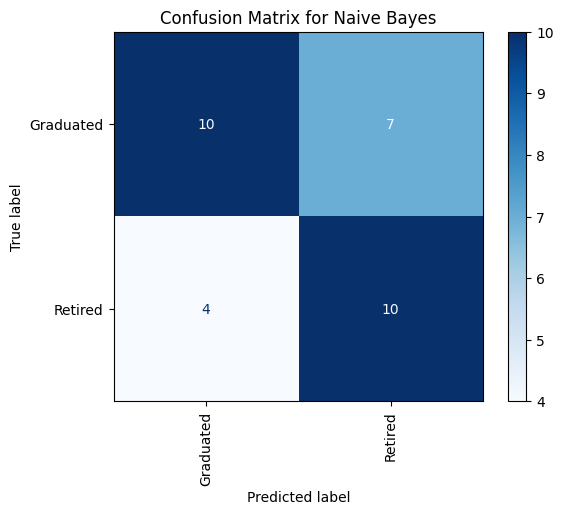

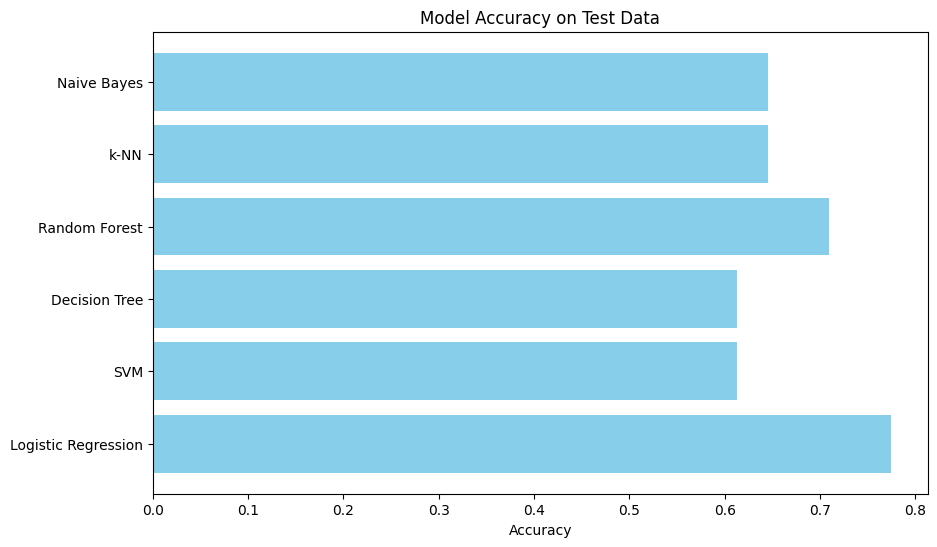

In [7]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
pd.options.mode.chained_assignment = None  # Suppress warnings

# Function to compute mean, std, and trend for each numerical feature
def extract_features(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features.remove("measurement_month")  
    
    feature_dict = {}
    for feature in numerical_features:
        values = df[["measurement_month", feature]].dropna()
        
        feature_dict[f"{feature}_mean"] = values[feature].mean()
        feature_dict[f"{feature}_std"] = values[feature].std()
        
        if len(values) > 1:
            slope, _ = np.polyfit(values["measurement_month"], values[feature], 1)
        else:
            slope = 0  # Default to 0 if insufficient data
        
        feature_dict[f"{feature}_trend"] = slope
    
    feature_dict["programming_lang"] = df["programming_lang"].mode()[0]  # Most common language
    
    return feature_dict

# Extract features for all projects
feature_list = []
for project, df in cleaned_data.items():
    features = extract_features(df)
    features["project"] = project
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)

# Merge with status data
data = features_df.merge(status_data, on="project").drop(columns=["project"])

# Define categorical and numerical features
categorical_features = ["programming_lang"]
numerical_features = [col for col in data.columns if col not in ["status"] + categorical_features]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Train-validation-test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["status"], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data["status"], random_state=42) 
# 0.125 of 80% = 10% of original data used for validation

X_train, y_train = train_data.drop(columns=["status"]), train_data["status"]
X_val, y_val = val_data.drop(columns=["status"]), val_data["status"]
X_test, y_test = test_data.drop(columns=["status"]), test_data["status"]

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegressionCV(
        cv=5,                    
        max_iter=1000,           
        random_state=42,
        n_jobs=-1,               
        penalty='l2',            
        solver='saga',           
        scoring='accuracy',     
        refit=True               
    ),
    "SVM": SVC(
        kernel='linear',        # Linear kernel for simplicity
        random_state=42, 
        max_iter=1000
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        max_depth=5,            # Limit depth to avoid overfitting
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    ),
    "k-NN": KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    ),
    "Naive Bayes": GaussianNB()
}

# Store accuracy results
model_accuracies = {}

# Train, evaluate, and display results for each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Create pipeline for each model
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Test evaluation
    y_test_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    model_accuracies[model_name] = accuracy

    print(f"Test Classification Report for {model_name}:\n", classification_report(y_test, y_test_pred))

    # Check if model has coefficients and print the top 5 important features
    if hasattr(model, "coef_"):
        # For models with coefficients (e.g., Logistic Regression, SVM)
        feature_importance = np.abs(model.coef_).flatten()
        
        # Get the feature names after preprocessing
        numerical_feature_names = numerical_features
        categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
        
        # Combine both feature sets
        all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])
        
        # Sort feature importance and get the top 5 features
        top_features_idx = np.argsort(feature_importance)[::-1][:5]  # Get indices of top 5 features
        top_feature_names = all_feature_names[top_features_idx]
        
        print(f"Top 5 important features for {model_name}: {top_feature_names}")
    else:
        print(f"{model_name} does not have coefficients to display.")

    # Confusion matrix
    display = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Plot the accuracies for each model
plt.figure(figsize=(10, 6))
plt.barh(list(model_accuracies.keys()), list(model_accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy on Test Data')
plt.show()


## Hyperparameter tuning for best performing models

/home/han/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-28 21:19:07,035] A new study created in memory with name: no-name-697de494-939d-4556-9f44-6b23ee67bb5d
/home/han/.local/lib/python3.10/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2025-02-28 21:19:10,009] Trial 7 finished with value: 0.8095238095238095 and parameters: {'n_estimators': 150, 'max_depth': 17}. Best is trial 7 with value: 0.8095238095238095.
[I 2025-02-28 21:19:10,943] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 250, 'max_depth': 4}. Best is trial 7 with value: 0.8095238095238095.
[I 2025-02-28 21:19:11,119] Trial 5 fin

Best Random Forest Hyperparameters: {'n_estimators': 300, 'max_depth': 8}
Best Random Forest Accuracy: 0.819047619047619
Best SVM Hyperparameters: {'C': 0.042322010647667184, 'max_iter': 5000}
Best SVM Accuracy: 0.7619047619047619
Best Logistic Regression Hyperparameters: {'C': 0.035530015854128405, 'max_iter': 1000}
Best Logistic Regression Accuracy: 0.7428571428571429
Final Test Accuracy for Random Forest: 0.7419
Best Hyperparameters for Random Forest: {'n_estimators': 300, 'max_depth': 8}
Final Model Classification Report for Random Forest:
              precision    recall  f1-score   support

   Graduated       0.71      0.88      0.79        17
     Retired       0.80      0.57      0.67        14

    accuracy                           0.74        31
   macro avg       0.76      0.73      0.73        31
weighted avg       0.75      0.74      0.73        31



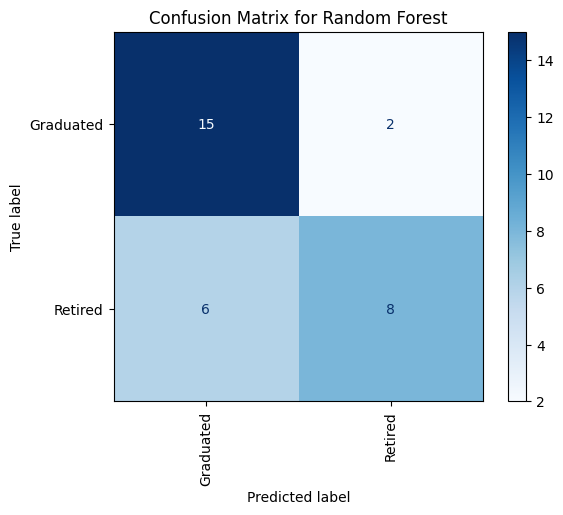

Final Test Accuracy for SVM: 0.6452
Best Hyperparameters for SVM: {'C': 0.042322010647667184, 'max_iter': 5000}
Final Model Classification Report for SVM:
              precision    recall  f1-score   support

   Graduated       0.67      0.71      0.69        17
     Retired       0.62      0.57      0.59        14

    accuracy                           0.65        31
   macro avg       0.64      0.64      0.64        31
weighted avg       0.64      0.65      0.64        31



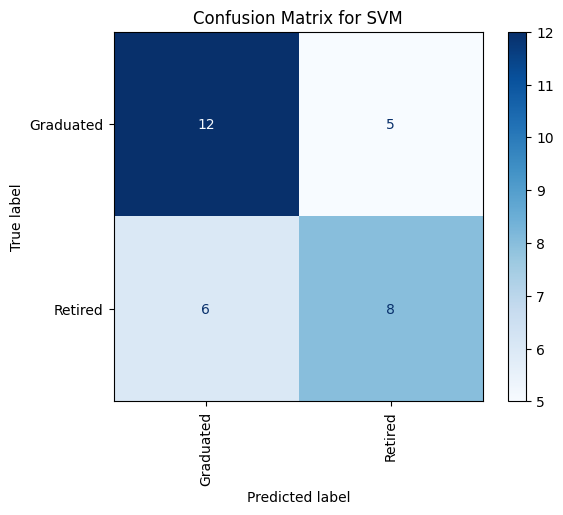

Final Test Accuracy for Logistic Regression: 0.7419
Best Hyperparameters for Logistic Regression: {'C': 0.035530015854128405, 'max_iter': 1000}
Final Model Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Graduated       0.74      0.82      0.78        17
     Retired       0.75      0.64      0.69        14

    accuracy                           0.74        31
   macro avg       0.74      0.73      0.74        31
weighted avg       0.74      0.74      0.74        31



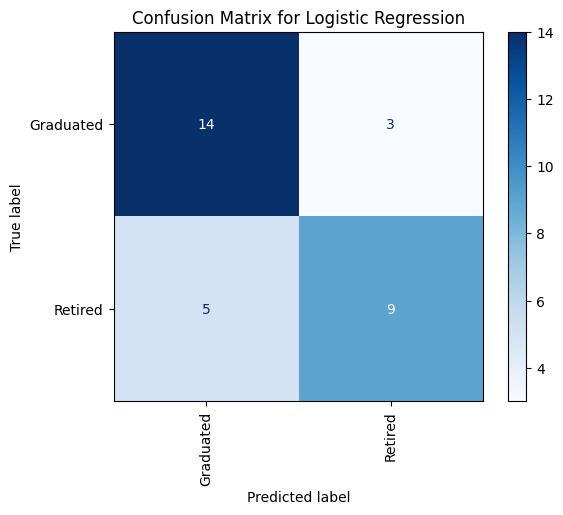

In [8]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

# Define a fixed random seed for reproducibility
random_seed = 42

# Define objective function for RandomForestClassifier
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=random_seed,
        n_jobs=-1
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # Cross-validation to evaluate performance
    accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return accuracy

# Define objective function for SVC
def svc_objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    max_iter = trial.suggest_int("max_iter", 1000, 10000, step=1000)
    model = SVC(
        kernel='linear',
        C=C,
        max_iter=max_iter,
        random_state=random_seed
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # Cross-validation to evaluate performance
    accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return accuracy

# Define objective function for LogisticRegressionCV
def lr_objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    max_iter = trial.suggest_int("max_iter", 1000, 10000, step=1000)
    model = LogisticRegressionCV(
        Cs=[C],
        cv=5,
        max_iter=max_iter,
        scoring='accuracy',
        random_state=random_seed,
        n_jobs=-1
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # Cross-validation to evaluate performance
    accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return accuracy

# Optimize hyperparameters for each model with a fixed seed
rf_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
rf_study.optimize(rf_objective, n_trials=50, n_jobs=-1)

svc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
svc_study.optimize(svc_objective, n_trials=50, n_jobs=-1)

lr_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
lr_study.optimize(lr_objective, n_trials=50, n_jobs=-1)

# Display best parameters and accuracy for each model
print("Best Random Forest Hyperparameters:", rf_study.best_trial.params)
print("Best Random Forest Accuracy:", rf_study.best_value)

print("Best SVM Hyperparameters:", svc_study.best_trial.params)
print("Best SVM Accuracy:", svc_study.best_value)

print("Best Logistic Regression Hyperparameters:", lr_study.best_trial.params)
print("Best Logistic Regression Accuracy:", lr_study.best_value)

# Evaluate each model using the best parameters
for model_name, study in [("Random Forest", rf_study), ("SVM", svc_study), ("Logistic Regression", lr_study)]:
    best_params = study.best_trial.params
    
    # Handle model-specific hyperparameters
    if model_name == "Random Forest":
        best_model = RandomForestClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            random_state=random_seed,
            n_jobs=-1
        )
    elif model_name == "SVM":
        best_model = SVC(
            kernel='linear',
            C=best_params["C"],
            max_iter=best_params["max_iter"],
            random_state=random_seed
        )
    else:  # Logistic Regression
        best_model = LogisticRegressionCV(
            Cs=[best_params["C"]],
            cv=5,
            max_iter=best_params["max_iter"],
            scoring='accuracy',
            random_state=random_seed,
            n_jobs=-1
        )

    # Final training on full dataset
    final_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", best_model)
    ])
    final_pipeline.fit(X_train, y_train)

    # Evaluate on test data
    y_test_pred = final_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Final Test Accuracy for {model_name}: {accuracy:.4f}")
    
    # Print the best hyperparameters for the model
    print(f"Best Hyperparameters for {model_name}: {best_params}")
    
    # Classification report
    print(f"Final Model Classification Report for {model_name}:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(final_pipeline, X_test, y_test, cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Transformer based model

In [9]:
import copy
cleaned_data_transformer = copy.deepcopy(cleaned_data)
for key, df in cleaned_data_transformer.items():
    cleaned_data_transformer[key] = df.drop(columns=['project', 'measurement_month'])


In [10]:
# import torch
# import random
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm

# # Set random seed for reproducibility
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# np.random.seed(42)
# random.seed(42)

# # Manually set device preference
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA GPU")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using Apple MPS")
# else:
#     device = torch.device("cpu")
#     print("Using CPU")

# # Step 1: Data Preprocessing
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# max_length = max(df.shape[0] for df in cleaned_data_transformer.values())

# data = []
# labels = []

# for project, df in cleaned_data_transformer.items():
#     text = df.drop(columns=['status']).astype(str).agg(' '.join, axis=1).tolist()
#     label = df['status'].iloc[0]  # status is constant within a project
#     labels.append(label)
#     while len(text) < max_length:
#         text.append("PAD")
#     data.append(" ".join(text))

# labels = [0 if label == 'Retired' else 1 for label in labels]  # Retired=0, Graduated=1

# class ProjectDataset(Dataset):
#     def __init__(self, data, labels, tokenizer, max_length):
#         self.data = data
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, item):
#         text = self.data[item]
#         label = self.labels[item]

#         encoding = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors='pt'
#         )

#         return {
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333, stratify=y_temp, random_state=42)

# train_dataset = ProjectDataset(X_train, y_train, tokenizer, max_length)
# val_dataset = ProjectDataset(X_val, y_val, tokenizer, max_length)
# test_dataset = ProjectDataset(X_test, y_test, tokenizer, max_length)

# # Step 3: Model Setup
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# # Freeze all layers except the classification head
# # for param in model.bert.parameters():
# #     param.requires_grad = False

# model = model.to(device)
# optimizer = AdamW(model.parameters(), lr=2e-5)

# def train_model(model, train_loader, val_loader, optimizer, epochs=20):
#     for epoch in range(epochs):
#         model.train()
#         total_train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
#             optimizer.zero_grad()
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             logits = outputs.logits

#             total_train_loss += loss.item()
#             _, predicted = torch.max(logits, dim=1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)

#             loss.backward()
#             optimizer.step()

#         model.eval()
#         correct_val = 0
#         total_val = 0
#         val_loss = 0

#         with torch.no_grad():
#             for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
#                 input_ids = batch['input_ids'].to(device)
#                 attention_mask = batch['attention_mask'].to(device)
#                 labels = batch['label'].to(device)

#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#                 val_loss += outputs.loss.item()

#                 logits = outputs.logits
#                 _, predicted = torch.max(logits, dim=1)
#                 correct_val += (predicted == labels).sum().item()
#                 total_val += labels.size(0)

#         print(f"Epoch {epoch+1} - Train Loss: {total_train_loss/len(train_loader)} | Train Acc: {correct_train/total_train}")
#         print(f"Epoch {epoch+1} - Val Loss: {val_loss/len(val_loader)} | Val Acc: {correct_val/total_val}")

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=64)

# train_model(model, train_loader, val_loader, optimizer, epochs=10)

# # Step 5: Test the Model
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in tqdm(test_loader, desc="Testing"):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         _, predicted = torch.max(logits, dim=1)

#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# test_acc = accuracy_score(all_labels, all_preds)
# print(f"Test Accuracy: {test_acc}")

# cm = confusion_matrix(all_labels, all_preds)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Retired', 'Graduated'], yticklabels=['Retired', 'Graduated'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data Preprocessing
max_length = max(df.shape[0] for df in cleaned_data_transformer.values())

data = []
labels = []

for project, df in cleaned_data_transformer.items():
    text = df.drop(columns=['status']).astype(str).agg(' '.join, axis=1).tolist()
    label = df['status'].iloc[0]
    labels.append(label)
    while len(text) < max_length:
        text.append("PAD")
    data.append(" ".join(text))

labels = [0 if label == 'Retired' else 1 for label in labels]  # Retired=0, Graduated=1

# Custom Dataset Class
class ProjectDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        text = self.data[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Training function with early stopping
def train_model(model, train_loader, val_loader, optimizer, epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            loss.backward()
            optimizer.step()

        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                logits = outputs.logits
                _, predicted = torch.max(logits, dim=1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val
        print(f"Epoch {epoch+1} - Train Loss: {total_train_loss/len(train_loader)} | Train Acc: {correct_train/total_train}")
        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss} | Val Acc: {val_acc}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return val_acc  # Return validation accuracy for this fold

# Hyperparameter tuning loops with K-Fold Cross Validation
k_folds = 5  # Number of cross-validation folds
dataset = ProjectDataset(data, labels, tokenizer, max_length)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

best_hyperparams = None
best_test_acc = 0.0

for dropout in [0.1, 0.2]:  # Reduce to 2 values
    for weight_decay in [0, 0.01, 0.1]:  # Keep 3 key values, removing 0.05
        for lr in [1e-5, 5e-5, 2e-4]:  # Keep 3 representative values (low, mid, high)
            for batch_size in [16, 32, 64]:  # Remove extreme small/large sizes
                fold_accs = []
                for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
                    print(f"Fold {fold+1}/{k_folds} - Training with dropout={dropout}, weight_decay={weight_decay}, lr={lr}, batch_size={batch_size}")

                    train_subset = Subset(dataset, train_idx)
                    val_subset = Subset(dataset, val_idx)

                    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_subset, batch_size=batch_size)

                    model = BertForSequenceClassification.from_pretrained(
                        'bert-base-uncased',
                        num_labels=2,
                        hidden_dropout_prob=dropout,
                        attention_probs_dropout_prob=dropout
                    ).to(device)

                    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

                    fold_acc = train_model(model, train_loader, val_loader, optimizer, epochs=30)
                    fold_accs.append(fold_acc)

                avg_acc = np.mean(fold_accs)
                print(f"Avg Validation Accuracy for dropout={dropout}, weight_decay={weight_decay}, lr={lr}, batch_size={batch_size}: {avg_acc}")

                # Final testing
                print("Final evaluation on test set...")
                model.eval()
                all_preds = []
                all_labels = []

                test_loader = DataLoader(dataset, batch_size=batch_size)

                with torch.no_grad():
                    for batch in tqdm(test_loader, desc="Testing"):
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['label'].to(device)

                        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                        logits = outputs.logits
                        _, predicted = torch.max(logits, dim=1)
                        all_preds.extend(predicted.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                test_acc = accuracy_score(all_labels, all_preds)

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_hyperparams = (dropout, weight_decay, lr, batch_size)

print("\n*** Best Hyperparameters ***")
print(f"Dropout: {best_hyperparams[0]}, Weight Decay: {best_hyperparams[1]}, Learning Rate: {best_hyperparams[2]}, Batch Size: {best_hyperparams[3]}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
